# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

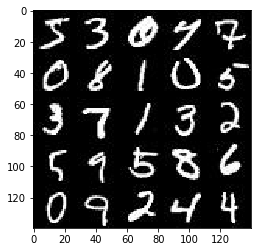

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

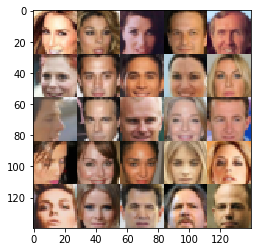

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Anaconda3\envs\dlnd\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(alpha, h):
    return tf.maximum(alpha * h, h)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = lrelu(alpha, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(alpha, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(alpha, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha=0.2
    
    #conv2d(inputs,filters,kernel_size,strides,padding)
    #W_out = (W−F+2P)/S + 1
    #H_out = (H-F+2P)/S + 1
    #D_out = K
    #W_out * H_out * D_out
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(alpha, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(alpha, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(alpha, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    alpha=0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    #tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
 
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.2619
Epoch 1/2... Discriminator Loss: 1.9067... Generator Loss: 0.3813
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 3.3146... Generator Loss: 0.0736
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 2.1450... Generator Loss: 0.2461
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.9096


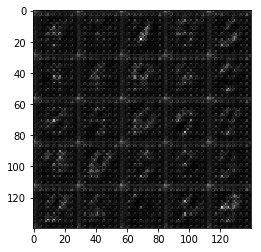

Epoch 1/2... Discriminator Loss: 1.8365... Generator Loss: 0.3449
Epoch 1/2... Discriminator Loss: 1.8019... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.5596... Generator Loss: 0.5637
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 1.5120
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.0663


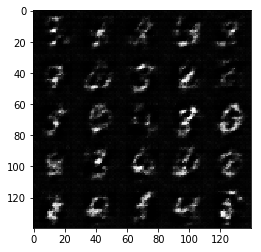

Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 1.1496
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.5756


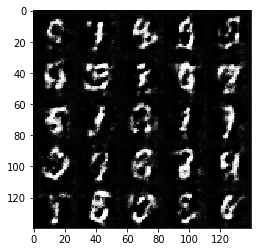

Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 1.2707
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.8164


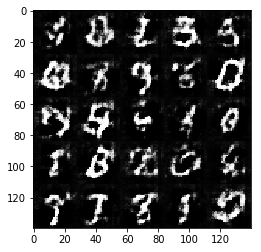

Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.1221
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 1.5488
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.5963
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.6030


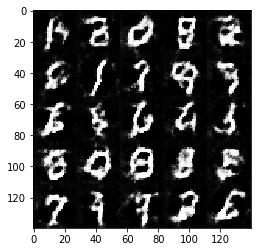

Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 1.2432
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 1.4286
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 2.1631
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.6739


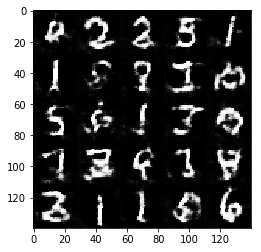

Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.3632
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 1.8795
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.5847
Epoch 1/2... Discriminator Loss: 1.7554... Generator Loss: 0.3350
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.9358


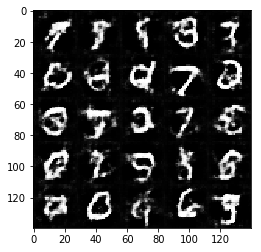

Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.4819
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.8736
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.4100
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.5499
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.3338
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.7780... Generator Loss: 0.3337


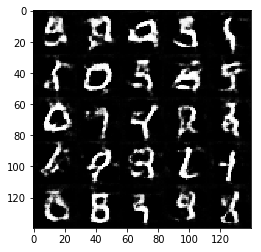

Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.5375
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 1.7922
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.3587
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 1.1412


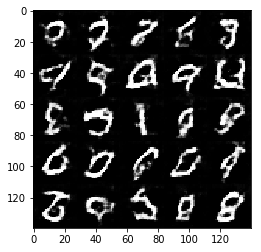

Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 1.2732
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.3760
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.8217


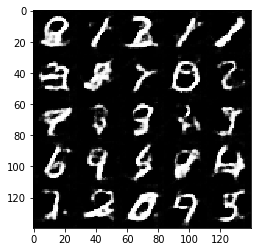

Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.2057... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 0.8752


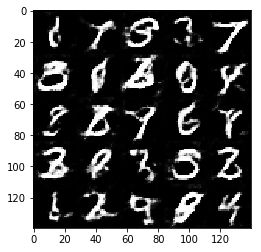

Epoch 1/2... Discriminator Loss: 1.6805... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.4090
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.4270
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 1.2080


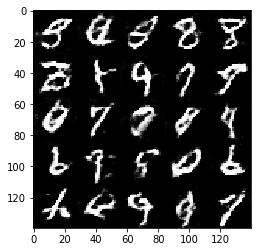

Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.3957
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.7548
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.7068
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.9067


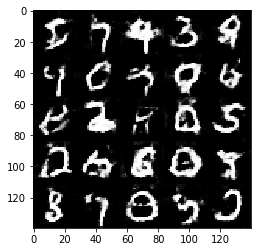

Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.5407
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.8647... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.1069
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.0768


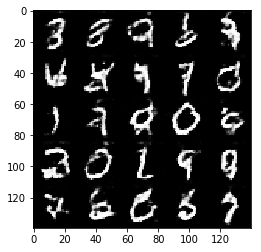

Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 0.9713
Epoch 1/2... Discriminator Loss: 1.8405... Generator Loss: 0.3783
Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 1.4187
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 1.7349
Epoch 1/2... Discriminator Loss: 0.7073... Generator Loss: 1.8824


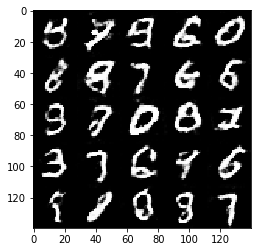

Epoch 1/2... Discriminator Loss: 1.8815... Generator Loss: 0.3145
Epoch 1/2... Discriminator Loss: 0.8256... Generator Loss: 1.5764
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.7096
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 1.4960
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.3498


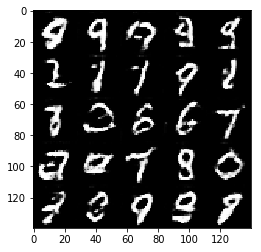

Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.1760
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.4382
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 0.9747
Epoch 1/2... Discriminator Loss: 0.5477... Generator Loss: 2.0601
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.1448


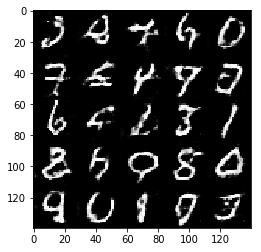

Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 1.0217
Epoch 1/2... Discriminator Loss: 1.6658... Generator Loss: 3.1366
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.8559


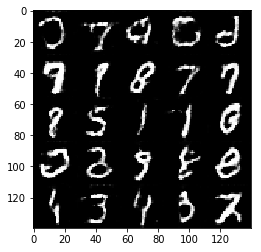

Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 1.6541
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.1471
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 0.4599
Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.6907
Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 1.7023... Generator Loss: 2.3471
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.2232


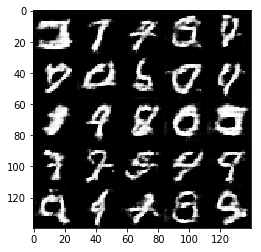

Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 1.0502
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.5451
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 1.3564
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 2.3592


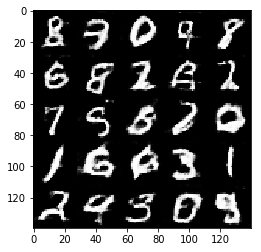

Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.1635
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.3831
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.4499
Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 1.0146
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.4577
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 1.4927


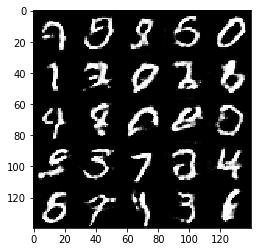

Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 1.1479
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.2461
Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 2.1643... Generator Loss: 0.2463
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 1.9110
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 1.4060
Epoch 2/2... Discriminator Loss: 0.7781... Generator Loss: 1.2757


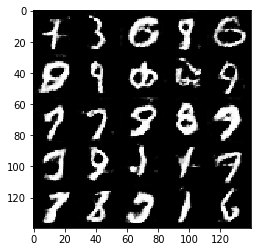

Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 1.6116
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.6756
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.7593
Epoch 2/2... Discriminator Loss: 0.6707... Generator Loss: 1.7076
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.7014
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.5245
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 2.3918


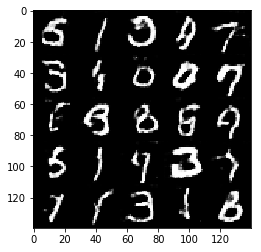

Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 1.4398
Epoch 2/2... Discriminator Loss: 1.5203... Generator Loss: 0.4650
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.5069
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 0.7260... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.0142


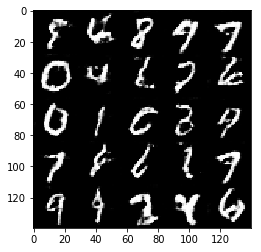

Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.5683
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 2.1301
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 2.8813
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.6257
Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.5651
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.6945


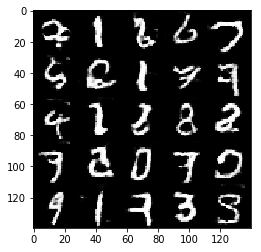

Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 2.4710
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.8507
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.5324
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 1.6754... Generator Loss: 3.8018
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 2.0789


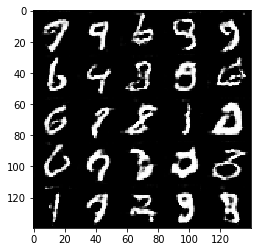

Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 0.5522... Generator Loss: 2.1147
Epoch 2/2... Discriminator Loss: 0.6386... Generator Loss: 1.5733
Epoch 2/2... Discriminator Loss: 1.0277... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.1042
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 2.4938
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.0630
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.0881


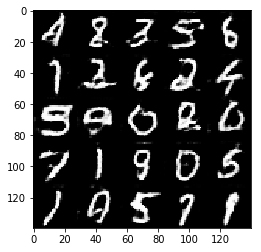

Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 2.4421
Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 1.4745
Epoch 2/2... Discriminator Loss: 1.4793... Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 1.4868
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.1698
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 0.9314


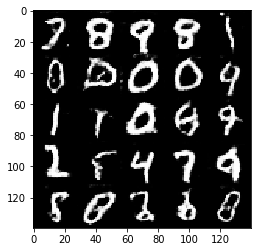

Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 2.2239
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 1.4091
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.5604
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.9548
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.0700


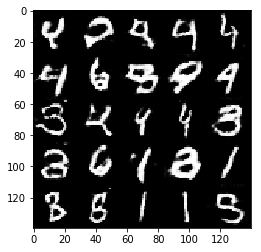

Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 2.0887
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.5680
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 1.3641
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.5849
Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 0.5927... Generator Loss: 1.8535
Epoch 2/2... Discriminator Loss: 0.7296... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 2.5818
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.0828


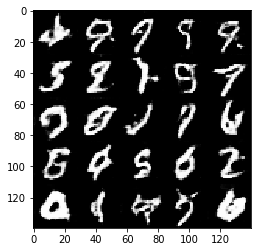

Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 0.5926... Generator Loss: 1.9696
Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 1.3665
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 2.3567
Epoch 2/2... Discriminator Loss: 0.5536... Generator Loss: 1.9466
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.8388
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 1.0170


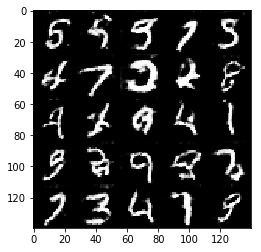

Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.6517
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.7939
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.3344
Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 2.6261
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.1247
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.5020
Epoch 2/2... Discriminator Loss: 0.8106... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.4924


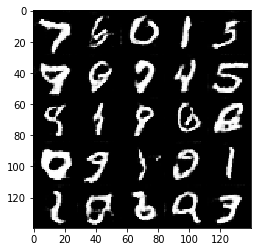

Epoch 2/2... Discriminator Loss: 0.6483... Generator Loss: 1.7278
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.4733
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 2.0393
Epoch 2/2... Discriminator Loss: 0.9594... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.3632
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.0705
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.5224


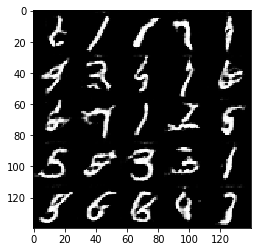

Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.1961
Epoch 2/2... Discriminator Loss: 0.4887... Generator Loss: 2.5664
Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 2.2660... Generator Loss: 5.2702
Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 2.1792
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 0.6244... Generator Loss: 1.6869
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.0743


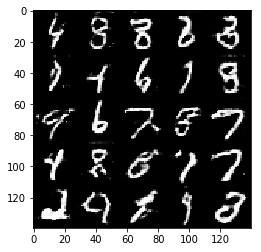

Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.5319
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.6268
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.7890
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.1837
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 1.6267
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.3385
Epoch 2/2... Discriminator Loss: 1.8133... Generator Loss: 4.2553
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.3703


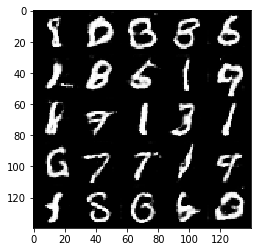

Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 0.6175... Generator Loss: 1.7815
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.3551
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 0.8400
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 0.5701... Generator Loss: 1.8478
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.9312


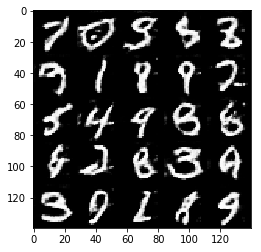

Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 1.5465
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 3.1247
Epoch 2/2... Discriminator Loss: 0.5725... Generator Loss: 1.9427
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 0.4767... Generator Loss: 2.3441
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.8762
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.4858
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.2998
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.5823


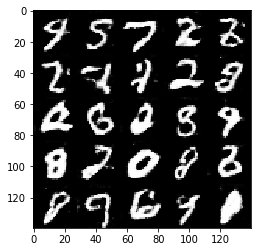

Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.3420
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.4196
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.7171
Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.5076


In [20]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6312... Generator Loss: 0.1837
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 7.7520
Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 7.5182
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 2.7948
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.1723


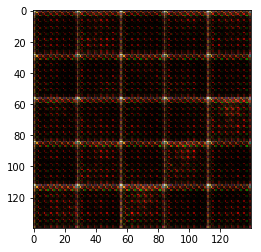

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 2.4794
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.7971... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.4577
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.1711


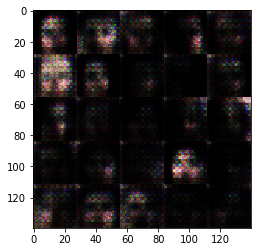

Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.7142
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.0759


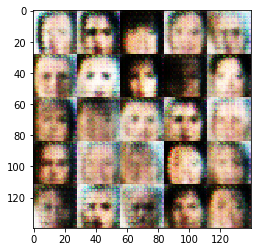

Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.8365... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.9093... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.6937... Generator Loss: 0.8316


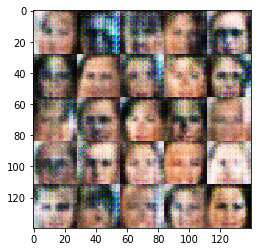

Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.7293


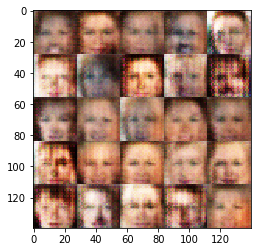

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5737


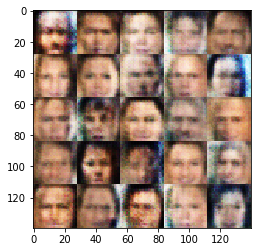

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.7910


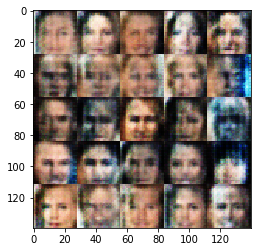

Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8517


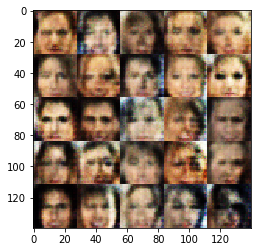

Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6699


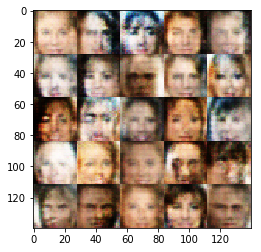

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7877


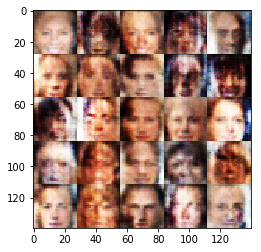

Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6730


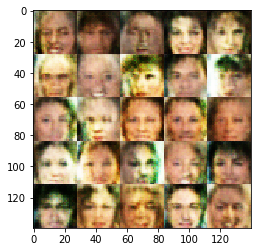

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7062


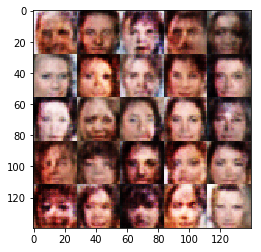

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6743


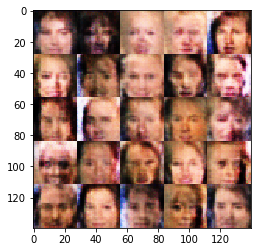

Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6860


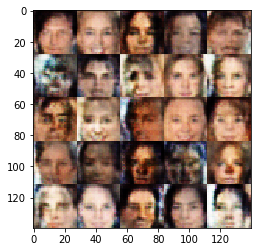

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.0089


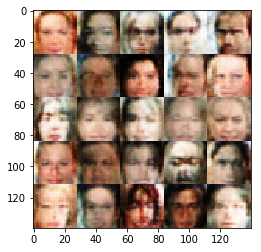

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6424


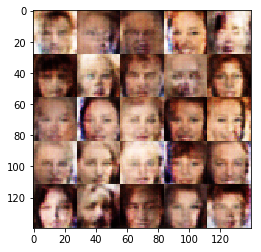

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.0425


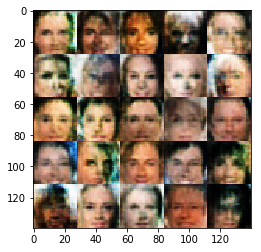

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.9540


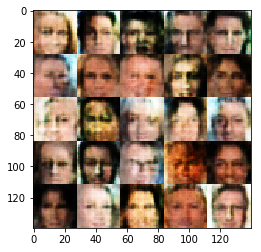

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.6891
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8543


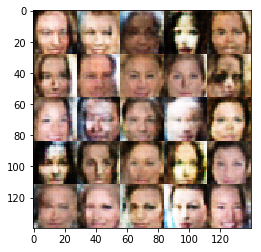

Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.4074
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.2368
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.5868


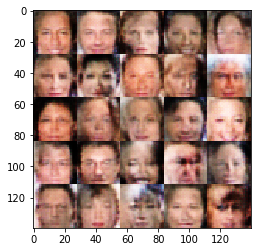

Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7261


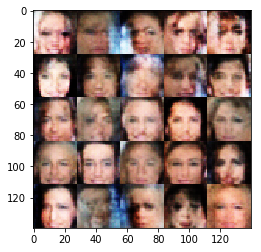

Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 1.5387


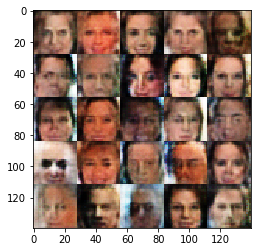

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.9089


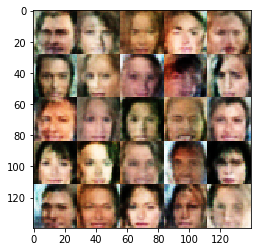

Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 2.1156
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.0810


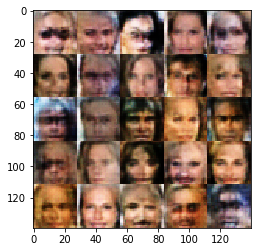

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.8270... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7081


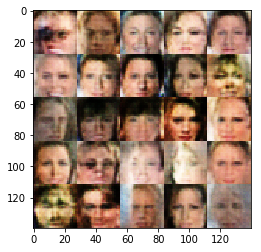

Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 2.0759


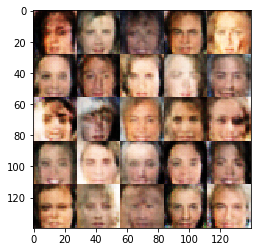

Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 2.1151


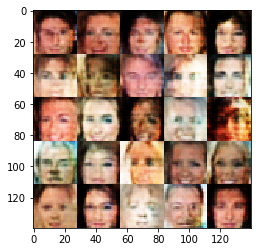

Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6946


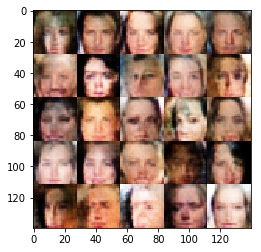

Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 2.5895
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 2.3860


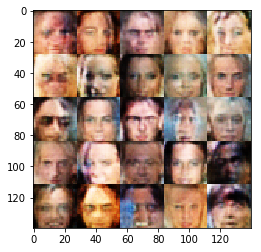

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 2.1306... Generator Loss: 0.2054
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 2.3189
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.1598
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.0635


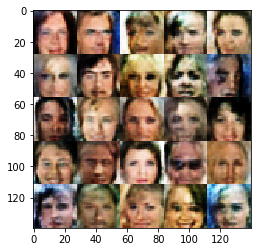

Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 3.4381
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 2.9877
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.7028... Generator Loss: 2.8446


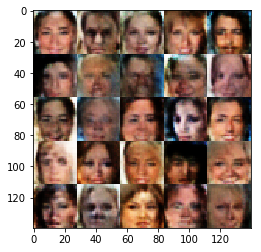

Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 2.0154
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 3.5615
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 1.9005
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 0.9868


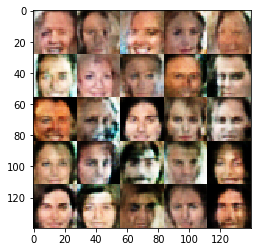

Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 3.0630
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.6048
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.4600
Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 2.3704
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 1.9530
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 3.6888
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 2.3063


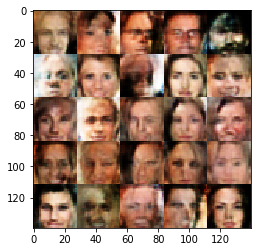

Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 4.5946
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 3.7254
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 2.2596
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 3.8036
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.6191
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 2.3590


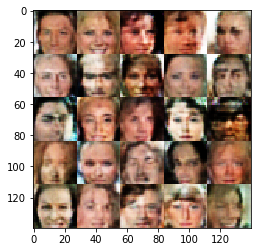

Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 3.2534
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 2.0068
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.0145
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 3.2537


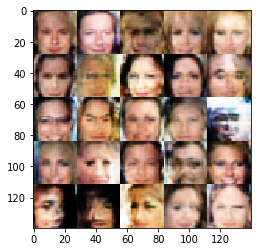

Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.8003
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 3.6636
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 2.8962
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.5670
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 2.3752
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 3.1181
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 2.2663


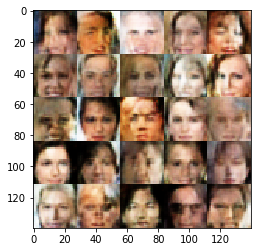

Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 3.5864
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.9489
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.3730
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.1083
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 5.5801
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 3.7075
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.5957
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.9872


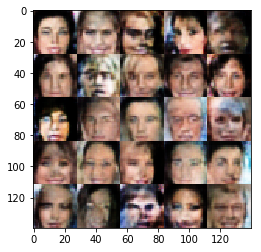

Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 2.6112
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 1.5222
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 3.0267
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.8818
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.2876
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.4082
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 3.0959
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 3.7552
Epoch 1/1... Discriminator Loss: 1.8076... Generator Loss: 0.3092


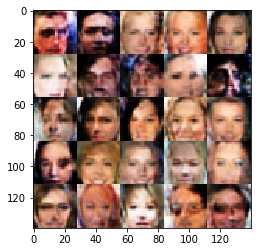

Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 3.0394
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.9073
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.8637
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 3.8460
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 2.0657
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 4.5096
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 0.3043


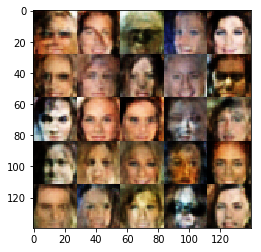

Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.6923
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.0771
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.2762
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 3.2056
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 2.6805
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 2.5235
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.4070


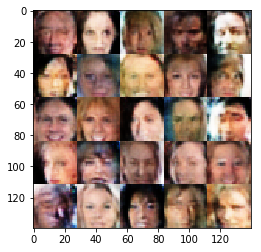

Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 6.4580
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 3.6070
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.8414
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.5577
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.4297
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 2.1696


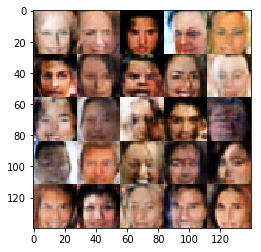

Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 4.1867
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 2.9664
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.4284
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 3.0085
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 2.0605
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 3.3531
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 3.8131
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 4.2520
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.2989


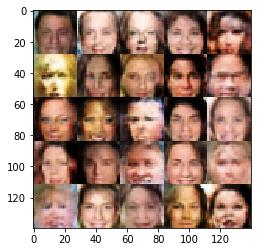

Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.8256
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 3.4945
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 4.1812
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 4.8827
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 4.1856
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.7440
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 2.6637
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.0043


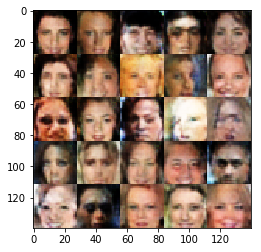

Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 3.5156
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.8500
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 2.4809
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 2.2668
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.3609
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 3.1949


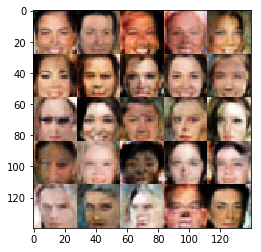

Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.2260
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 3.2145
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 3.4980
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.2952
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.2195
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 2.3380
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.2463
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.6133
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 2.1583


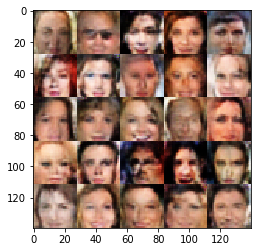

Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 2.9465
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 4.0295
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 3.3927
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 3.8301
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 3.2853
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.9632
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.8149
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 2.8185
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 3.2018


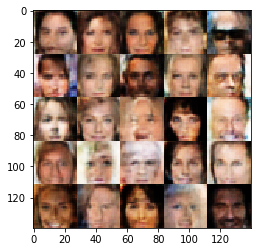

Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 5.9198
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 4.2333
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.7109
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 2.6304
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.6856
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.4282


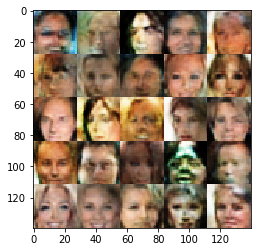

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.4902
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.5830
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 3.7242
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.4748
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.8167
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 5.1675
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.5007
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.6132
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 2.7283


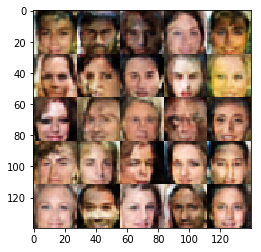

Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 1.7355
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 1.9265
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.9000
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 3.8583
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 2.9624
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 2.9684
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.3003


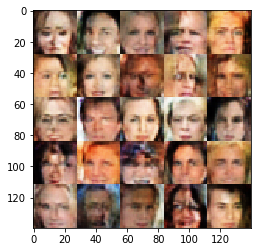

Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 2.5664
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.1166
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.9607
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 2.2760
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 3.1573
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.3207


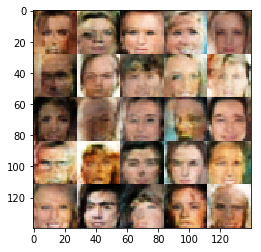

Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.4505
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 3.6548
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 3.4148
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 2.5773
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 2.5937
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 2.8536
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.1444
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.4740


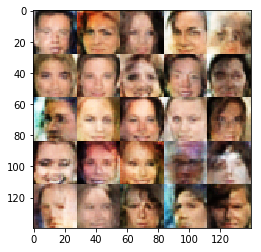

Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 2.0925
Epoch 1/1... Discriminator Loss: 3.0387... Generator Loss: 0.1821
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 2.0942
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.1572
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.1043
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.5023
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 2.8424
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 2.5274
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 2.1858
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 3.0420


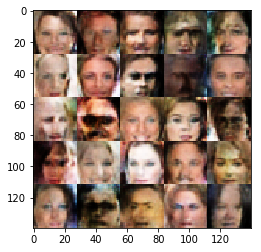

Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 4.4077
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 4.8086
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 3.1280
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 2.8096
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 5.1232
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 1.6330
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 5.3358


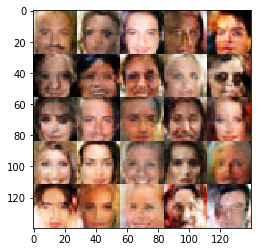

Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.0904
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 4.5614
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 2.6994
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.1092
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 3.9118
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 5.0080
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 2.9762
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.4179


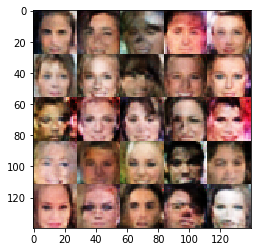

Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.5966
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.3895
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 3.4862
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 2.6199
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 4.3098
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 4.4776


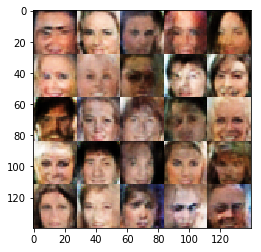

Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 5.1250
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 5.6947
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 3.6875
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 4.2361
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 4.0347
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 5.1024
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 4.5707
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.4908
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 2.9852
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.2445


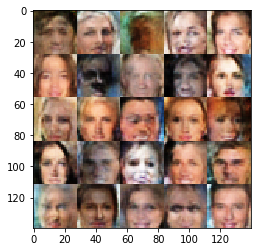

Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 4.4240
Epoch 1/1... Discriminator Loss: 2.7632... Generator Loss: 0.1482
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 3.1782
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 2.2982
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.8395
Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 2.5637
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 3.4096
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.8100
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 4.1012


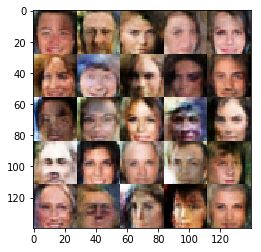

Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 4.0428
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 3.5659
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 5.1394
Epoch 1/1... Discriminator Loss: 2.0363... Generator Loss: 0.2997
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.7950
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 2.9744
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.0481
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 3.7750
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.3271


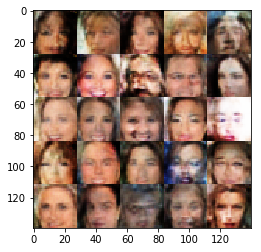

Epoch 1/1... Discriminator Loss: 0.4169... Generator Loss: 3.0791
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.1189
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 5.2573
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.9346
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 2.7562
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 3.0423
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 3.5102


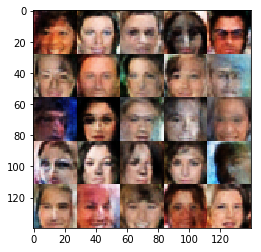

Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 2.9696
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 4.4240
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 4.9847
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.8426
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 3.3896
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 4.9487
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 3.3542
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 2.7539
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 2.3144


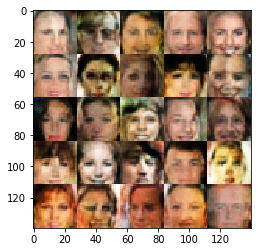

Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 2.7594
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 3.7622
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.7809
Epoch 1/1... Discriminator Loss: 2.0867... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.4487
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 2.8217
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 3.5552
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 2.2345... Generator Loss: 0.2539


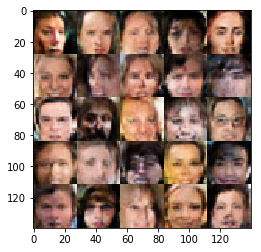

Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 2.1607
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 4.2953
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.9587
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 3.6938
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 2.4878
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 3.1538
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 2.5827
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.8244
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 4.8487
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 3.7323


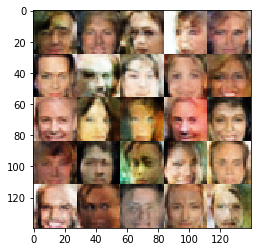

Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 2.9466
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.6775
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 2.0119
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.2931
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 2.7857
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 3.1906
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 1.7727


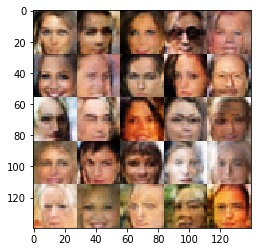

Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 5.3188
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.2832
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.5832


In [21]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.